In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from keras.layers import Input,Conv2D,BatchNormalization,Dense,Dropout,Flatten,Activation,GlobalAveragePooling2D,Multiply,Add,Concatenate,Average
from keras.regularizers import l2
from tensorflow.keras import initializers,optimizers
from scipy.io import loadmat
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from scipy import signal
from sklearn.model_selection import train_test_split


d:\Code\Anaconda\envs\mytensorflowenv\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.11) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def load_data(filepath, sampling):
    rawdata = np.zeros((7, 24, sampling*4, 15)) #(num_classes, num_channels, num_samples, num_blocks)
    block = 0
    for i in range(1,16):
        traildata = loadmat(filepath + 'block' + str(i) + '.mat')
        traildata = traildata['data']
        print(traildata.shape)

        #去除闪烁刺激
        data = np.zeros((7, 24, sampling*4))
        cuetime = 1 # 1秒提示
        trailtime = 4 # 4秒闪烁刺激
        for j in range(7):
            # print((cuetime+trailtime)*sampling - cuetime*sampling)
            data[j,:,:] = np.array(traildata[:, cuetime*sampling:(cuetime+trailtime)*sampling])
            cuetime += 5

        rawdata[:, :, :, block] = np.array(data)
        block += 1
    return rawdata

In [3]:
#滤波 6-50Hz
def band_filter_process(input):
    
    b_HPF,a_HPF = signal.butter(4, 0.04, btype='highpass') #4阶，6Hz ， 6/(sampling_rate/2) 和iirfilter效果一样
    b_LPF,a_LPF = signal.butter(4, 0.33333333, btype='lowpass') #4阶，50Hz ，50/(sampling_rate/2) 和iirfilter效果一样
    
    data_HF = signal.filtfilt(b_HPF, a_HPF, input) #零相位滤波，滤两次，反向多滤了一次
    band = signal.filtfilt(b_LPF, a_LPF, data_HF) #6-50
    
    return band

In [4]:
def get_feature_data(rawData, channels, num_targets, num_blocks, simpling_rate, time_length=1, trail_length=4):
    window_length = int(simpling_rate * time_length) 
    data_length = 1200
    fft_scale = int(data_length/window_length) #4

    trainData = []
    trainLabel = []

    for j in range(num_targets): #7个targets
        targets_index = j
        for k in range(num_blocks): #15个block
            block_index = k

            channel1_data = rawData[targets_index,channels[0],:,block_index] #O1
            channel2_data = rawData[targets_index,channels[1],:,block_index] #O2
            channel3_data = rawData[targets_index,channels[2],:,block_index] #T3
            channel4_data = rawData[targets_index,channels[3],:,block_index] #T6
            channel5_data = rawData[targets_index,channels[4],:,block_index] #P3
            channel6_data = rawData[targets_index,channels[5],:,block_index] #P4
            channel7_data = rawData[targets_index,channels[6],:,block_index] #C3
            channel8_data = rawData[targets_index,channels[7],:,block_index] #C4
            channel9_data = rawData[targets_index,channels[8],:,block_index] #Cz

            yd4_1 = band_filter_process(channel1_data) #滤波
            yd4_2 = band_filter_process(channel2_data)
            yd4_3 = band_filter_process(channel3_data)
            yd4_4 = band_filter_process(channel4_data)
            yd4_5 = band_filter_process(channel5_data)
            yd4_6 = band_filter_process(channel6_data)
            yd4_7 = band_filter_process(channel7_data)
            yd4_8 = band_filter_process(channel8_data)
            yd4_9 = band_filter_process(channel9_data)

            for m in range(fft_scale):
                yd4_1_fft = np.fft.rfft(yd4_1[m*window_length:(m+1)*window_length],data_length)/window_length
                yd4_2_fft = np.fft.rfft(yd4_2[m*window_length:(m+1)*window_length],data_length)/window_length
                yd4_3_fft = np.fft.rfft(yd4_3[m*window_length:(m+1)*window_length],data_length)/window_length
                yd4_4_fft = np.fft.rfft(yd4_4[m*window_length:(m+1)*window_length],data_length)/window_length
                yd4_5_fft = np.fft.rfft(yd4_5[m*window_length:(m+1)*window_length],data_length)/window_length
                yd4_6_fft = np.fft.rfft(yd4_6[m*window_length:(m+1)*window_length],data_length)/window_length
                yd4_7_fft = np.fft.rfft(yd4_7[m*window_length:(m+1)*window_length],data_length)/window_length
                yd4_8_fft = np.fft.rfft(yd4_8[m*window_length:(m+1)*window_length],data_length)/window_length
                yd4_9_fft = np.fft.rfft(yd4_9[m*window_length:(m+1)*window_length],data_length)/window_length

                trainData.append(np.array([np.concatenate((np.real(yd4_1_fft)[round(5/0.25):round(55/0.25) + 1],np.imag(yd4_1_fft)[round(5/0.25):round(55/0.25) + 1]),axis=0),
                                            np.concatenate((np.real(yd4_2_fft)[round(5/0.25):round(55/0.25) + 1],np.imag(yd4_2_fft)[round(5/0.25):round(55/0.25) + 1]),axis=0),
                                            np.concatenate((np.real(yd4_3_fft)[round(5/0.25):round(55/0.25) + 1],np.imag(yd4_3_fft)[round(5/0.25):round(55/0.25) + 1]),axis=0),
                                            np.concatenate((np.real(yd4_4_fft)[round(5/0.25):round(55/0.25) + 1],np.imag(yd4_4_fft)[round(5/0.25):round(55/0.25) + 1]),axis=0),
                                            np.concatenate((np.real(yd4_5_fft)[round(5/0.25):round(55/0.25) + 1],np.imag(yd4_5_fft)[round(5/0.25):round(55/0.25) + 1]),axis=0),
                                            np.concatenate((np.real(yd4_6_fft)[round(5/0.25):round(55/0.25) + 1],np.imag(yd4_6_fft)[round(5/0.25):round(55/0.25) + 1]),axis=0),
                                            np.concatenate((np.real(yd4_7_fft)[round(5/0.25):round(55/0.25) + 1],np.imag(yd4_7_fft)[round(5/0.25):round(55/0.25) + 1]),axis=0),
                                            np.concatenate((np.real(yd4_8_fft)[round(5/0.25):round(55/0.25) + 1],np.imag(yd4_8_fft)[round(5/0.25):round(55/0.25) + 1]),axis=0),
                                            np.concatenate((np.real(yd4_9_fft)[round(5/0.25):round(55/0.25) + 1],np.imag(yd4_9_fft)[round(5/0.25):round(55/0.25) + 1]),axis=0)
                                            ]))

                trainLabel.append(targets_index)
    trainData = np.expand_dims(np.array(trainData),axis=-1)
    trainLabel = np.array(trainLabel)
    return trainData, trainLabel



In [5]:
#添加了注意力机制
def acnn_model(input_shape, decay):
    input = Input(shape=input_shape)
    
    
    #conv1
    input_x = Conv2D(2*8, kernel_size=(9, 1), 
                     padding="valid", kernel_regularizer=l2(decay), 
                     kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None))(input)
    input_x = BatchNormalization()(input_x)
    input_x = Activation('relu')(input_x)
    input_x = Dropout(0.25)(input_x)
    
    #conv2
    input_x = Conv2D(2*8, kernel_size=(1, 10), 
                     kernel_regularizer=l2(decay), padding="valid", 
                     kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None))(input_x)
    input_x = BatchNormalization()(input_x)
    input_x = Activation('relu')(input_x)
    input_x = Dropout(0.25)(input_x)
    
    #se
    input_x_2 = GlobalAveragePooling2D()(input_x)
    input_x_2 = Dense(units=2,activation='relu',use_bias=False,kernel_regularizer=l2(l=decay))(input_x_2)
    input_x_2 = Dense(units=16, activation='sigmoid', use_bias=False,kernel_regularizer=l2(l=decay))(input_x_2)
    input_x = Multiply()([input_x,input_x_2])
    
    #output
    input_x = Flatten()(input_x)
    x = Dense(7, activation='softmax', 
                    kernel_regularizer=l2(decay), 
                    kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None))(input_x)
    
    model = tf.keras.Model(inputs=input,outputs=x)
    
    return model

In [6]:
# filepath='../../Datasets/private/subject3/matdata/'
filepath='../../stimulate/SSVEP_BCI/data/class/s1/'
rawdata = load_data(filepath, 300)
channels = [14, 15, 0, 6, 13, 22, 1, 5, 7]
# channels = [1, 2, 3, 4, 5, 7]
trainData, trainLabel = get_feature_data(rawdata, channels, 7, 9, 300)


FileNotFoundError: [Errno 2] No such file or directory: '../../stimulate/SSVEP_BCI/data/class/s1/block1.mat'

In [7]:
label_binarizer = LabelBinarizer() #标签二值化
train_labels_one_hot = label_binarizer.fit_transform(trainLabel)
X_train, X_test, y_train, y_test = train_test_split(trainData, train_labels_one_hot, test_size=0.2, random_state=42)

In [8]:
EEG_model = acnn_model((9,402,1),decay = 0.0001)
sgd = optimizers.SGD(learning_rate=0.001, decay=0, momentum=0.9, nesterov=False)
EEG_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = EEG_model.fit(X_train, y_train, epochs=120, batch_size=64, verbose=0, validation_split = 0.1)
test_loss, test_acc = EEG_model.evaluate(X_test, y_test, verbose=1)

3/3 [==============================] - 0s 5ms/step - loss: 1.8770 - accuracy: 0.3095


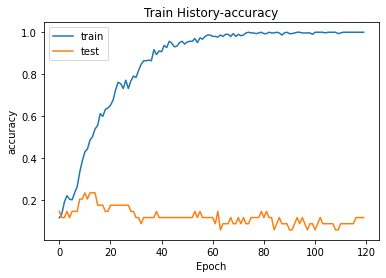

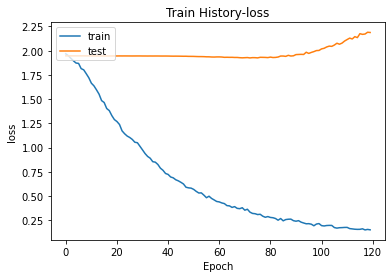

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train History-accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train History-loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
#10折交叉验证
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(trainData)
label_binarizer = LabelBinarizer() #标签二值化
train_labels_one_hot = label_binarizer.fit_transform(trainLabel)

acc_per = [0]*10
per_index = 0

for train_index, test_index in kf.split(trainData):
    x_tr, x_ts = trainData[train_index], trainData[test_index]
    label_tr, label_ts = train_labels_one_hot[train_index], train_labels_one_hot[test_index]

    EEG_model = acnn_model((9,402,1),decay = 0.0001)
    sgd = optimizers.SGD(learning_rate=0.001, decay=0, momentum=0.9, nesterov=False)
    EEG_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    history = EEG_model.fit(x_tr, label_tr, epochs=150, batch_size=64, verbose=0)
    test_loss, test_acc = EEG_model.evaluate(x_ts, label_ts,verbose=0)
    print("第%d次准确率: %.4f，共测试了%d组数据 " % ((per_index+1),test_acc, len(label_ts)))
    acc_per[per_index] = test_acc
    per_index+= 1
print("avg is %.2f%% (+/- %.2f%%)" % (np.mean(acc_per)*100, np.std(acc_per)*100))

第1次准确率: 0.6667，共测试了42组数据 
第2次准确率: 0.7619，共测试了42组数据 
第3次准确率: 0.6905，共测试了42组数据 
第4次准确率: 0.7381，共测试了42组数据 
第5次准确率: 0.6905，共测试了42组数据 
第6次准确率: 0.6905，共测试了42组数据 
第7次准确率: 0.6429，共测试了42组数据 
第8次准确率: 0.7143，共测试了42组数据 
第9次准确率: 0.6905，共测试了42组数据 
第10次准确率: 0.7619，共测试了42组数据 
avg is 70.48% (+/- 3.72%)
